In [ ]:
import pandas as pd
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/CS 8803-CAI/unbalanced_train_segments.csv'
df = pd.read_csv(file_path, skiprows=1)

df.head(5)
print(df.columns)


Index(['# YTID', ' start_seconds', ' end_seconds', ' positive_labels'], dtype='object')


In [ ]:
import pandas as pd

csv_file = '/content/drive/MyDrive/CS 8803-CAI/filtered_data.csv'
df = pd.read_csv(csv_file)

df.columns = df.columns.str.strip()

target_labels = ["/t/dd00031", "/t/dd00032", "/t/dd00033", "/t/dd00034", "/t/dd00035", "/t/dd00036", "/t/dd00037"]

def contains_target_labels(labels):
    label_list = labels.split(',')
    return any(label in label_list for label in target_labels)

filtered_df = df[df['positive_labels'].apply(contains_target_labels)]

def filter_to_target_labels(labels):
    label_list = labels.split(',')
    filtered_labels = [label for label in label_list if label in target_labels]
    return filtered_labels

filtered_df['positive_labels'] = filtered_df['positive_labels'].apply(filter_to_target_labels)

filtered_df = filtered_df[filtered_df['positive_labels'].apply(lambda x: len(x) == 1)]

filtered_df['positive_labels'] = filtered_df['positive_labels'].apply(lambda x: ','.join(x))

filtered_df.to_csv('/content/drive/MyDrive/CS 8803-CAI/filtered_data.csv', index=False)

print(filtered_df.head(5))
filtered_df.info()

        # YTID  start_seconds  end_seconds positive_labels
0  --3flh9REUI           30.0         40.0      /t/dd00034
1  --9yPWZVYZw           30.0         40.0      /t/dd00035
2  --CZ-8vrQ1g           30.0         40.0      /t/dd00031
3  --K3100xfu8           30.0         40.0      /t/dd00033
4  --PLvH-OZRI           30.0         40.0      /t/dd00035
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8014 entries, 0 to 8013
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   # YTID           8014 non-null   object 
 1   start_seconds    8014 non-null   float64
 2   end_seconds      8014 non-null   float64
 3   positive_labels  8014 non-null   object 
dtypes: float64(2), object(2)
memory usage: 250.6+ KB


In [ ]:
!pip install --upgrade pytube
!pip install yt-dlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 51.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import yt_dlp as youtube_dl
import os

csv_file = '/content/drive/MyDrive/CS 8803-CAI/filtered_data.csv'
data = pd.read_csv(csv_file)

data.columns = data.columns.str.strip().str.replace('#', '')
data.columns = data.columns.str.strip()

label_mapping = {
    "/t/dd00031": "happy",
    "/t/dd00032": "funny",
    "/t/dd00033": "sad",
    "/t/dd00034": "tender",
    "/t/dd00035": "exciting",
    "/t/dd00036": "angry",
    "/t/dd00037": "scary"
}

def download_audio_yt(ytid, start_sec, end_sec, labels, output_folder="/content/output"):
    yt_link = f"https://www.youtube.com/watch?v={ytid}"
    download_path = os.path.join(output_folder, f"{ytid}.mp4")

    ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': download_path,
        'noplaylist': True,
    }

    try:
        with youtube_dl.YoutubeDL(ydl_opts) as ydl:
            ydl.download([yt_link])

        print(f"Downloaded {ytid} successfully.")

        from pydub import AudioSegment

        audio = AudioSegment.from_file(download_path)
        clipped_audio = audio[start_sec * 1000:end_sec * 1000]

        label_list = labels.split(",")
        mapped_labels = [label_mapping.get(label.strip(), label.strip()) for label in label_list]
        label_str = "_".join(mapped_labels).replace("/", "_")

        wav_path = os.path.join(output_folder, f"{ytid}_{label_str}.wav")
        clipped_audio.export(wav_path, format="wav")
        print(f"Saved {wav_path}")

        os.remove(download_path)

    except Exception as e:
        print(f"Failed to process {ytid}: {e}")

output_folder = '/content/drive/MyDrive/CS 8803-CAI/output_audio'

os.makedirs(output_folder, exist_ok=True)

for _, row in data.iterrows():
    ytid = row['YTID']
    start_seconds = row['start_seconds']
    end_seconds = row['end_seconds']
    labels = row['positive_labels']

    download_audio_yt(ytid, start_seconds, end_seconds, labels, output_folder)

In [ ]:
import os
import librosa
import numpy as np

SR = 16000

input_folder = '/content/drive/MyDrive/CS 8803-CAI/output_audio'
output_folder = '/content/drive/MyDrive/CS 8803-CAI/output_npy'

os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith(".wav"):
        input_wavfile = os.path.join(input_folder, filename)
        output_npyfile = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}.npy")

        audio, sr = librosa.load(input_wavfile, sr=SR)

        assert sr == SR, f"Expected sample rate {SR}, but got {sr} for file {input_wavfile}"

        np.save(output_npyfile, audio)
        print(f"Saved {output_npyfile}")

In [ ]:
import numpy as np
import torch
import librosa
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
data_path = '/content/drive/MyDrive/CS 8803-CAI/output_npy'
label_mapping = {'happy': 0, 'exciting': 1, 'scary': 2, 'funny': 3, 'sad': 4, 'tender': 5, 'angry': 6}

spectrograms = []
labels = []

for file in os.listdir(data_path):
    if file.endswith(".npy"):
        data = np.load(os.path.join(data_path, file))
        spectrogram = librosa.feature.melspectrogram(y=data, sr=22050, n_mels=128)

        spectrogram = torch.tensor(spectrogram, dtype=torch.float32).unsqueeze(0)
        spectrograms.append(spectrogram)

        temp = file.split('_')[-1]
        emotion = temp.split('.')[0]
        labels.append(label_mapping[emotion])

max_width = max([spectrogram.shape[1] for spectrogram in spectrograms])
print("Max width:", max_width)

def pad_or_truncate(spectrogram, target_width):
    current_width = spectrogram.shape[2]
    if current_width < target_width:
        padding = target_width - current_width
        spectrogram = torch.nn.functional.pad(spectrogram, (0, padding), mode='constant', value=0)
    elif current_width > target_width:
        spectrogram = spectrogram[:, :, :target_width]
    return spectrogram

target_width = max_width

padded_spectrograms = [pad_or_truncate(s, target_width) for s in spectrograms]
X = torch.stack(padded_spectrograms)
y = torch.tensor(labels)

dataset = TensorDataset(X, y)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


Max width: 128


In [ ]:
model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(model.fc.in_features, 7)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
from torch.utils.data import DataLoader, random_split, Subset

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    accuracy = 100 * correct_predictions / total_predictions
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")


Epoch [1/10], Loss: 1.5884, Accuracy: 45.92%
Epoch [2/10], Loss: 1.3793, Accuracy: 51.88%
Epoch [3/10], Loss: 1.3473, Accuracy: 52.82%
Epoch [4/10], Loss: 1.2979, Accuracy: 54.55%
Epoch [5/10], Loss: 1.2716, Accuracy: 55.13%
Epoch [6/10], Loss: 1.2318, Accuracy: 56.03%
Epoch [7/10], Loss: 1.1892, Accuracy: 57.68%
Epoch [8/10], Loss: 1.1794, Accuracy: 57.09%
Epoch [9/10], Loss: 1.1578, Accuracy: 57.52%
Epoch [10/10], Loss: 1.1530, Accuracy: 58.35%


In [ ]:
model.eval()

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

accuracy = 100 * correct_predictions / total_predictions
print(f"Testing Accuracy: {accuracy:.2f}%")

Testing Accuracy: 25.94%


In [ ]:
model.eval()

with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        features = model(inputs)
        print("Vector representations of inputs:")
        print(features.cpu().numpy())
        break

Vector representations of inputs:
[[-2.7683148   1.9283223   0.4535321  -0.940624   -8.734132   -4.2365084
   1.6808825 ]
 [-1.2166642   1.5600713   0.31670475 -2.6851635  -2.9450452  -0.98354936
   2.8968835 ]
 [-0.61767817  2.8860376  -0.94414186 -1.3645546  -3.9870615  -0.9909452
   1.5644269 ]
 [-1.1683532   1.5050309   0.20953429 -2.649603   -2.8161163  -0.88593745
   2.8025303 ]
 [-0.23981154  1.2897038  -1.5073016  -1.5080466  -2.7690754   0.2875998
  -0.62965876]
 [-0.06056835  3.4330554  -3.2767134   0.41623938 -3.8865585  -0.3212618
  -0.18243955]
 [ 0.14424361  3.9385068  -3.287328    0.8716248  -4.601668   -0.53244495
  -0.47933227]
 [-0.6655876   2.928668   -0.7811377  -1.234638   -4.2219505  -1.1244824
   1.7338212 ]
 [-1.9765209   1.3083484   0.8196197  -1.667199   -5.996345   -3.5840626
   3.492167  ]
 [-1.2140899   1.5652796   0.30996612 -2.677569   -2.9480429  -0.983074
   2.891357  ]
 [ 0.4304294   3.0693045  -3.2385015   0.20270859 -3.2421985   0.31272662
  -1.52367

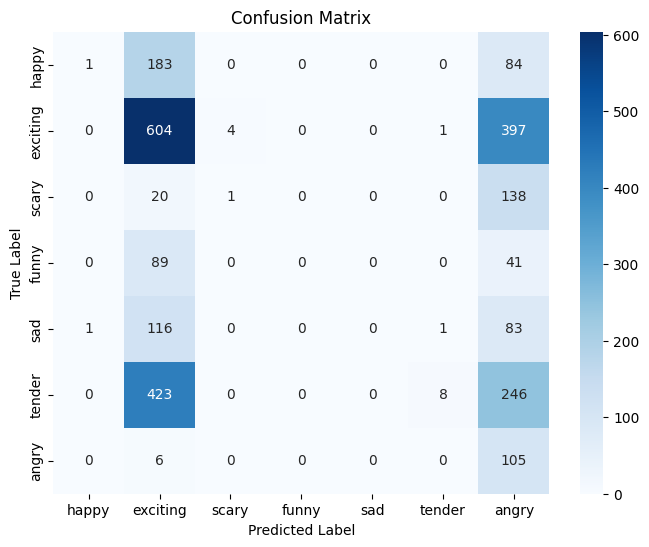

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=label_mapping.keys()))

              precision    recall  f1-score   support

       happy       0.50      0.00      0.01       268
    exciting       0.42      0.60      0.49      1006
       scary       0.20      0.01      0.01       159
       funny       0.00      0.00      0.00       130
         sad       0.00      0.00      0.00       201
      tender       0.80      0.01      0.02       677
       angry       0.10      0.95      0.17       111

    accuracy                           0.28      2552
   macro avg       0.29      0.22      0.10      2552
weighted avg       0.45      0.28      0.21      2552



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


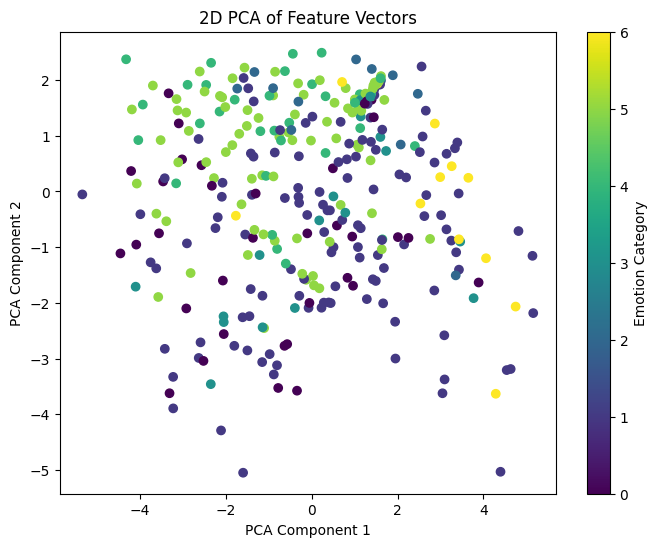

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

model.eval()
features = []
labels_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        features.extend(outputs.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels_list, cmap='viridis')
plt.colorbar(label='Emotion Category')
plt.title('2D PCA of Feature Vectors')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()